In [ ]:
def log2(x):
    return int(np.log2(x))

batch_sizes = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 2, 10: 1}
train_step_ratio = {k: batch_sizes[2] / v for k, v in batch_sizes.items()}

ds_train = keras.utils.image_dataset_from_directory(
    "landscapes/train", label_mode=None, image_size=(64, 64), batch_size=32
)


def resize_image(res, image):
    image = tf.image.resize(
        image, (res, res), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    return image


def create_dataloader(res):
    batch_size = batch_sizes[log2(res)]
    dl = ds_train.map(partial(resize_image, res), num_parallel_calls=tf.data.AUTOTUNE).unbatch()
    dl = dl.shuffle(200).batch(batch_size, drop_remainder=True).prefetch(1).repeat()
    return dl

Found 3455 files belonging to 1 classes.


2023-06-03 00:09:33.117800: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8916 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:8a:00.0, compute capability: 6.1


In [ ]:
def fade_in(alpha, a, b):
    return alpha * a + (1.0 - alpha) * b


def wasserstein_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * y_pred)


def pixel_norm(x, epsilon=1e-8):
    return x / tf.math.sqrt(tf.reduce_mean(x ** 2, axis=-1, keepdims=True) + epsilon)


def minibatch_std(input_tensor, epsilon=1e-8):
    n, h, w, c = tf.shape(input_tensor)
    group_size = tf.minimum(4, n)
    x = tf.reshape(input_tensor, [group_size, -1, h, w, c])
    group_mean, group_var = tf.nn.moments(x, axes=(0), keepdims=False)
    group_std = tf.sqrt(group_var + epsilon)
    avg_std = tf.reduce_mean(group_std, axis=[1, 2, 3], keepdims=True)
    x = tf.tile(avg_std, [group_size, h, w, 1])
    return tf.concat([input_tensor, x], axis=-1)


class EqualizedConv(layers.Layer):
    def __init__(self, out_channels, kernel=3, gain=2, **kwargs):
        super().__init__(**kwargs)
        self.kernel = kernel
        self.out_channels = out_channels
        self.gain = gain
        self.pad = kernel != 1

    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
        self.w = self.add_weight(
            shape=[self.kernel, self.kernel, self.in_channels, self.out_channels],
            initializer=initializer,
            trainable=True,
            name="kernel",
        )
        self.b = self.add_weight(
            shape=(self.out_channels,), initializer="zeros", trainable=True, name="bias"
        )
        fan_in = self.kernel * self.kernel * self.in_channels
        self.scale = tf.sqrt(self.gain / fan_in)

    def call(self, inputs):
        if self.pad:
            x = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="REFLECT")
        else:
            x = inputs
        output = (
            tf.nn.conv2d(x, self.scale * self.w, strides=1, padding="VALID") + self.b
        )
        return output


class EqualizedDense(layers.Layer):
    def __init__(self, units, gain=2, learning_rate_multiplier=1, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.gain = gain
        self.learning_rate_multiplier = learning_rate_multiplier

    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = keras.initializers.RandomNormal(
            mean=0.0, stddev=1.0 / self.learning_rate_multiplier
        )
        self.w = self.add_weight(
            shape=[self.in_channels, self.units],
            initializer=initializer,
            trainable=True,
            name="kernel",
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="zeros", trainable=True, name="bias"
        )
        fan_in = self.in_channels
        self.scale = tf.sqrt(self.gain / fan_in)

    def call(self, inputs):
        output = tf.add(tf.matmul(inputs, self.scale * self.w), self.b)
        return output * self.learning_rate_multiplier


class AddNoise(layers.Layer):
    def build(self, input_shape):
        n, h, w, c = input_shape[0]
        initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
        self.b = self.add_weight(
            shape=[1, 1, 1, c], initializer=initializer, trainable=True, name="kernel"
        )

    def call(self, inputs):
        x, noise = inputs
        output = x + self.b * noise
        return output


class AdaIN(layers.Layer):
    def __init__(self, gain=1, **kwargs):
        super().__init__(**kwargs)
        self.gain = gain

    def build(self, input_shapes):
        x_shape = input_shapes[0]
        w_shape = input_shapes[1]

        self.w_channels = w_shape[-1]
        self.x_channels = x_shape[-1]

        self.dense_1 = EqualizedDense(self.x_channels, gain=1)
        self.dense_2 = EqualizedDense(self.x_channels, gain=1)

    def call(self, inputs):
        x, w = inputs
        ys = tf.reshape(self.dense_1(w), (-1, 1, 1, self.x_channels))
        yb = tf.reshape(self.dense_2(w), (-1, 1, 1, self.x_channels))
        return ys * x + yb

In [ ]:
def Mapping(num_stages, input_shape=512):
    z = layers.Input(shape=(input_shape))
    w = pixel_norm(z)
    for i in range(8):
        w = EqualizedDense(512, learning_rate_multiplier=0.01)(w)
        w = layers.LeakyReLU(0.2)(w)
    w = tf.tile(tf.expand_dims(w, 1), (1, num_stages, 1))
    return keras.Model(z, w, name="mapping")


class Generator:
    def __init__(self, start_res_log2, target_res_log2):
        self.start_res_log2 = start_res_log2
        self.target_res_log2 = target_res_log2
        self.num_stages = target_res_log2 - start_res_log2 + 1
        self.g_blocks = []
        self.to_rgb = []
        self.noise_inputs = []
        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512,  # 4x4
            3: 512,  # 8x8
            4: 512,  # 16x16
            5: 512,  # 32x32
            6: 256,  # 64x64
        }

        start_res = 2 ** start_res_log2
        self.input_shape = (start_res, start_res, self.filter_nums[start_res_log2])
        self.g_input = layers.Input(self.input_shape, name="generator_input")

        for i in range(start_res_log2, target_res_log2 + 1):
            filter_num = self.filter_nums[i]
            res = 2 ** i
            self.noise_inputs.append(
                layers.Input(shape=(res, res, 1), name=f"noise_{res}x{res}")
            )
            to_rgb = Sequential(
                [
                    layers.InputLayer(input_shape=(res, res, filter_num)),
                    EqualizedConv(3, 1, gain=1),
                ],
                name=f"to_rgb_{res}x{res}",
            )
            self.to_rgb.append(to_rgb)
            is_base = i == self.start_res_log2
            if is_base:
                input_shape = (res, res, self.filter_nums[i - 1])
            else:
                input_shape = (2 ** (i - 1), 2 ** (i - 1), self.filter_nums[i - 1])
            g_block = self.build_block(
                filter_num, res=res, input_shape=input_shape, is_base=is_base
            )
            self.g_blocks.append(g_block)

    def build_block(self, filter_num, res, input_shape, is_base):
        input_tensor = layers.Input(shape=input_shape, name=f"g_{res}")
        noise = layers.Input(shape=(res, res, 1), name=f"noise_{res}")
        w = layers.Input(shape=512)
        x = input_tensor

        if not is_base:
            x = layers.UpSampling2D((2, 2))(x)
            x = EqualizedConv(filter_num, 3)(x)

        x = AddNoise()([x, noise])
        x = layers.LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])

        x = EqualizedConv(filter_num, 3)(x)
        x = AddNoise()([x, noise])
        x = layers.LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])
        return keras.Model([input_tensor, w, noise], x, name=f"genblock_{res}x{res}")

    def grow(self, res_log2):
        res = 2 ** res_log2

        num_stages = res_log2 - self.start_res_log2 + 1
        w = layers.Input(shape=(self.num_stages, 512), name="w")

        alpha = layers.Input(shape=(1), name="g_alpha")
        x = self.g_blocks[0]([self.g_input, w[:, 0], self.noise_inputs[0]])

        if num_stages == 1:
            rgb = self.to_rgb[0](x)
        else:
            for i in range(1, num_stages - 1):

                x = self.g_blocks[i]([x, w[:, i], self.noise_inputs[i]])

            old_rgb = self.to_rgb[num_stages - 2](x)
            old_rgb = layers.UpSampling2D((2, 2))(old_rgb)

            i = num_stages - 1
            x = self.g_blocks[i]([x, w[:, i], self.noise_inputs[i]])

            new_rgb = self.to_rgb[i](x)

            rgb = fade_in(alpha[0], new_rgb, old_rgb)

        return keras.Model(
            [self.g_input, w, self.noise_inputs, alpha],
            rgb,
            name=f"generator_{res}_x_{res}",
        )


class Discriminator:
    def __init__(self, start_res_log2, target_res_log2):
        self.start_res_log2 = start_res_log2
        self.target_res_log2 = target_res_log2
        self.num_stages = target_res_log2 - start_res_log2 + 1
        # filter size to use at each stage, keys are log2(resolution)
        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512,  # 4x4
            3: 512,  # 8x8
            4: 512,  # 16x16
            5: 512,  # 32x32
            6: 256,  # 64x64
        }
        self.d_blocks = []
        self.from_rgb = []

        for res_log2 in range(self.start_res_log2, self.target_res_log2 + 1):
            res = 2 ** res_log2
            filter_num = self.filter_nums[res_log2]
            from_rgb = Sequential(
                [
                    layers.InputLayer(
                        input_shape=(res, res, 3), name=f"from_rgb_input_{res}"
                    ),
                    EqualizedConv(filter_num, 1),
                    layers.LeakyReLU(0.2),
                ],
                name=f"from_rgb_{res}",
            )

            self.from_rgb.append(from_rgb)

            input_shape = (res, res, filter_num)
            if len(self.d_blocks) == 0:
                d_block = self.build_base(filter_num, res)
            else:
                d_block = self.build_block(
                    filter_num, self.filter_nums[res_log2 - 1], res
                )

            self.d_blocks.append(d_block)

    def build_base(self, filter_num, res):
        input_tensor = layers.Input(shape=(res, res, filter_num), name=f"d_{res}")
        x = minibatch_std(input_tensor)
        x = EqualizedConv(filter_num, 3)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Flatten()(x)
        x = EqualizedDense(filter_num)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = EqualizedDense(1)(x)
        return keras.Model(input_tensor, x, name=f"d_{res}")

    def build_block(self, filter_num_1, filter_num_2, res):
        input_tensor = layers.Input(shape=(res, res, filter_num_1), name=f"d_{res}")
        x = EqualizedConv(filter_num_1, 3)(input_tensor)
        x = layers.LeakyReLU(0.2)(x)
        x = EqualizedConv(filter_num_2)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.AveragePooling2D((2, 2))(x)
        return keras.Model(input_tensor, x, name=f"d_{res}")

    def grow(self, res_log2):
        res = 2 ** res_log2
        idx = res_log2 - self.start_res_log2
        alpha = layers.Input(shape=(1), name="d_alpha")
        input_image = layers.Input(shape=(res, res, 3), name="input_image")
        x = self.from_rgb[idx](input_image)
        x = self.d_blocks[idx](x)
        if idx > 0:
            idx -= 1
            downsized_image = layers.AveragePooling2D((2, 2))(input_image)
            y = self.from_rgb[idx](downsized_image)
            x = fade_in(alpha[0], x, y)

            for i in range(idx, -1, -1):
                x = self.d_blocks[i](x)
        return keras.Model([input_image, alpha], x, name=f"discriminator_{res}_x_{res}")

In [ ]:
class StyleGAN(tf.keras.Model):
    def __init__(self, z_dim=512, target_res=64, start_res=4):
        super().__init__()
        self.z_dim = z_dim

        self.target_res_log2 = log2(target_res)
        self.start_res_log2 = log2(start_res)
        self.current_res_log2 = self.target_res_log2
        self.num_stages = self.target_res_log2 - self.start_res_log2 + 1

        self.alpha = tf.Variable(1.0, dtype=tf.float32, trainable=False, name="alpha")

        self.mapping = Mapping(num_stages=self.num_stages)
        self.d_builder = Discriminator(self.start_res_log2, self.target_res_log2)
        self.g_builder = Generator(self.start_res_log2, self.target_res_log2)
        self.g_input_shape = self.g_builder.input_shape

        self.phase = None
        self.train_step_counter = tf.Variable(0, dtype=tf.int32, trainable=False)

        self.loss_weights = {"gradient_penalty": 10, "drift": 0.001}

    def grow_model(self, res):
        tf.keras.backend.clear_session()
        res_log2 = log2(res)
        self.generator = self.g_builder.grow(res_log2)
        self.discriminator = self.d_builder.grow(res_log2)
        self.current_res_log2 = res_log2
        print(f"\nModel resolution:{res}x{res}")

    def compile(
        self, steps_per_epoch, phase, res, d_optimizer, g_optimizer, *args, **kwargs
    ):
        self.loss_weights = kwargs.pop("loss_weights", self.loss_weights)
        self.steps_per_epoch = steps_per_epoch
        if res != 2 ** self.current_res_log2:
            self.grow_model(res)
            self.d_optimizer = d_optimizer
            self.g_optimizer = g_optimizer

        self.train_step_counter.assign(0)
        self.phase = phase
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        super().compile(*args, **kwargs)

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def generate_noise(self, batch_size):
        noise = [
            tf.random.normal((batch_size, 2 ** res, 2 ** res, 1))
            for res in range(self.start_res_log2, self.target_res_log2 + 1)
        ]
        return noise

    def gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=tf.range(1, tf.size(tf.shape(loss))))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        return loss

    def train_step(self, real_images):

        self.train_step_counter.assign_add(1)

        if self.phase == "TRANSITION":
            self.alpha.assign(
                tf.cast(self.train_step_counter / self.steps_per_epoch, tf.float32)
            )
        elif self.phase == "STABLE":
            self.alpha.assign(1.0)
        else:
            raise NotImplementedError
        alpha = tf.expand_dims(self.alpha, 0)
        batch_size = tf.shape(real_images)[0]
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)

        z = tf.random.normal((batch_size, self.z_dim))
        const_input = tf.ones(tuple([batch_size] + list(self.g_input_shape)))
        noise = self.generate_noise(batch_size)

        # generator
        with tf.GradientTape() as g_tape:
            w = self.mapping(z)
            fake_images = self.generator([const_input, w, noise, alpha])
            pred_fake = self.discriminator([fake_images, alpha])
            g_loss = wasserstein_loss(real_labels, pred_fake)

            trainable_weights = (
                self.mapping.trainable_weights + self.generator.trainable_weights
            )
            gradients = g_tape.gradient(g_loss, trainable_weights)
            self.g_optimizer.apply_gradients(zip(gradients, trainable_weights))

        # discriminator
        with tf.GradientTape() as gradient_tape, tf.GradientTape() as total_tape:
            # forward pass
            pred_fake = self.discriminator([fake_images, alpha])
            pred_real = self.discriminator([real_images, alpha])

            epsilon = tf.random.uniform((batch_size, 1, 1, 1))
            interpolates = epsilon * real_images + (1 - epsilon) * fake_images
            gradient_tape.watch(interpolates)
            pred_fake_grad = self.discriminator([interpolates, alpha])

            # calculate losses
            loss_fake = wasserstein_loss(fake_labels, pred_fake)
            loss_real = wasserstein_loss(real_labels, pred_real)
            loss_fake_grad = wasserstein_loss(fake_labels, pred_fake_grad)

            # gradient penalty
            gradients_fake = gradient_tape.gradient(loss_fake_grad, [interpolates])
            gradient_penalty = self.loss_weights[
                "gradient_penalty"
            ] * self.gradient_loss(gradients_fake)

            # drift loss
            all_pred = tf.concat([pred_fake, pred_real], axis=0)
            drift_loss = self.loss_weights["drift"] * tf.reduce_mean(all_pred ** 2)

            d_loss = loss_fake + loss_real + gradient_penalty + drift_loss

            gradients = total_tape.gradient(
                d_loss, self.discriminator.trainable_weights
            )
            self.d_optimizer.apply_gradients(
                zip(gradients, self.discriminator.trainable_weights)
            )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

    def call(self, inputs: dict()):
        style_code = inputs.get("style_code", None)
        z = inputs.get("z", None)
        noise = inputs.get("noise", None)
        batch_size = inputs.get("batch_size", 1)
        alpha = inputs.get("alpha", 1.0)
        alpha = tf.expand_dims(alpha, 0)
        if style_code is None:
            if z is None:
                z = tf.random.normal((batch_size, self.z_dim))
            style_code = self.mapping(z)

        if noise is None:
            noise = self.generate_noise(batch_size)

        # self.alpha.assign(alpha)

        const_input = tf.ones(tuple([batch_size] + list(self.g_input_shape)))
        images = self.generator([const_input, style_code, noise, alpha])
        images = np.clip((images * 0.5 + 0.5) * 255, 0, 255).astype(np.uint8)

        return images

In [ ]:
START_RES = 4
TARGET_RES = 64

style_gan = StyleGAN(start_res=START_RES, target_res=TARGET_RES)

In [ ]:
def plot_images(images, log2_res, fname=""):
    scales = {2: 0.5, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8}
    scale = scales[log2_res]

    grid_col = min(images.shape[0], int(32 // scale))
    grid_row = 1

    f, axarr = plt.subplots(
        grid_row, grid_col, figsize=(10, 10)
    )

    for row in range(grid_row):
        ax = axarr if grid_row == 1 else axarr[row]
        for col in range(grid_col):
            ax[col].imshow(images[row * grid_col + col])
            ax[col].axis("off")
    plt.show()
    if fname:
        f.savefig(fname)

In [ ]:
import torch
from torchvision.utils import make_grid

def train(start_res=4,target_res=64,steps_per_epoch=5000,display_images=True,):
    opt_cfg = {"learning_rate": 1e-3, "beta_1": 0.0, "beta_2": 0.99, "epsilon": 1e-8}

    val_batch_size = 16
    val_z = tf.random.normal((val_batch_size, style_gan.z_dim))
    val_noise = style_gan.generate_noise(val_batch_size)

    start_res_log2 = int(np.log2(start_res))
    target_res_log2 = int(np.log2(target_res))

    for res_log2 in range(start_res_log2, target_res_log2 + 1):
        res = 2 ** res_log2
        print(res_log2)
        for phase in ["TRANSITION", "STABLE"]:
            if res == start_res and phase == "TRANSITION":
                continue

            train_dl = create_dataloader(res)

            steps = int(train_step_ratio[res_log2] * steps_per_epoch)

            style_gan.compile(
                d_optimizer=tf.keras.optimizers.legacy.Adam(**opt_cfg),
                g_optimizer=tf.keras.optimizers.legacy.Adam(**opt_cfg),
                loss_weights={"gradient_penalty": 10, "drift": 0.001},
                steps_per_epoch=steps,
                res=res,
                phase=phase,
                run_eagerly=False,
            )

            prefix = f"res_{res}x{res}_{style_gan.phase}"

            ckpt_cb = keras.callbacks.ModelCheckpoint(
                f"checkpoints/stylegan_{res}x{res}.ckpt",
                save_weights_only=True,
                verbose=0,
            )
            print(phase)
            style_gan.fit(train_dl, epochs=1, steps_per_epoch=steps, callbacks=[ckpt_cb])

#             if display_images:
#                 images = style_gan({"z": val_z, "noise": val_noise, "alpha": 1.0})
#                 plot_images(images, res_log2)
    images = style_gan({"z": val_z, "noise": val_noise, "alpha": 1.0})
    print(images.shape)
    plot_images(images, res_log2)






2

Model resolution:4x4
STABLE


2023-06-03 00:09:36.944816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]
2023-06-03 00:09:36.945423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]
2023-06-03 00:09:43.217457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


10000/10000 [==============================] - 266s 26ms/step - d_loss: -5.0342 - g_loss: 3.2363
3

Model resolution:8x8
TRANSITION


2023-06-03 00:14:03.345592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]
2023-06-03 00:14:03.346690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]


10000/10000 [==============================] - 610s 60ms/step - d_loss: -3.7857 - g_loss: 2.5153
STABLE


2023-06-03 00:24:13.399577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]
2023-06-03 00:24:13.400232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]


10000/10000 [==============================] - 623s 62ms/step - d_loss: -2.8701 - g_loss: 1.4592
4

Model resolution:16x16
TRANSITION


2023-06-03 00:34:37.090303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]
2023-06-03 00:34:37.090926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]


10000/10000 [==============================] - 1360s 135ms/step - d_loss: -1.3567 - g_loss: 2.6340
STABLE


2023-06-03 00:57:16.773339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]
2023-06-03 00:57:16.773966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]


10000/10000 [==============================] - 1360s 136ms/step - d_loss: 1.5454 - g_loss: 0.6564
5

Model resolution:32x32
TRANSITION


2023-06-03 01:19:57.878127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]
2023-06-03 01:19:57.878699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]


10000/10000 [==============================] - 3738s 373ms/step - d_loss: -0.5871 - g_loss: 3.4250
STABLE


2023-06-03 02:22:16.420536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]
2023-06-03 02:22:16.421359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]


10000/10000 [==============================] - 3727s 372ms/step - d_loss: 1.9587 - g_loss: 1.9827
6

Model resolution:64x64
TRANSITION


2023-06-03 03:24:24.002375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]
2023-06-03 03:24:24.003369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]


10000/10000 [==============================] - 7867s 785ms/step - d_loss: 6.5715 - g_loss: 5.0970
STABLE


2023-06-03 05:35:31.067351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]
2023-06-03 05:35:31.068166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3455]
	 [[{{node Placeholder/_0}}]]


10000/10000 [==============================] - 7853s 784ms/step - d_loss: 3.9382 - g_loss: 5.6203
(16, 64, 64, 3)


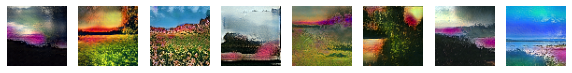

In [ ]:
import warnings

# Code that produces warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
train(start_res=4, target_res=64, steps_per_epoch=10000, display_images=False)

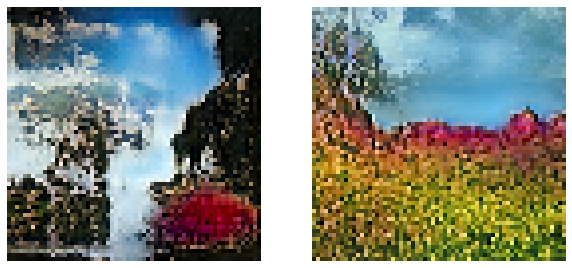

In [ ]:
#tf.random.set_seed(196)
batch_size = 2
z = tf.random.normal((batch_size, style_gan.z_dim))
w = style_gan.mapping(z)
noise = style_gan.generate_noise(batch_size=batch_size)
images = style_gan({"style_code": w, "noise": noise, "alpha": 1.0})
plot_images(images, 5)

(-0.5, 191.5, 63.5, -0.5)

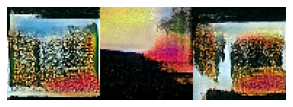

In [ ]:
alpha = 0.5
w_mix = np.expand_dims(alpha * w[0] + (1 - alpha) * w[1], 0)
noise_a = [np.expand_dims(n[0], 0) for n in noise]
mix_images = style_gan({"style_code": w_mix, "noise": noise_a})
image_row = np.hstack([images[0], images[1], mix_images[0]])
plt.figure(figsize=(5, 5))
plt.imshow(image_row)
plt.axis("off")



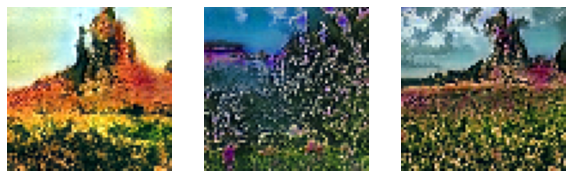

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)
plt.imshow(images[0])
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(images[1])
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(mix_images[0])
plt.axis("off")
plt.show()

In [ ]:
def plot_images2(images, log2_res, fname=""):
    scales = {2: 0.5, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8}
    scale = scales[log2_res]

#     grid_col = min(images.shape[0], int(32 // scale))
#     grid_row = 1
    grid_col = 4
    grid_row = 4
    f, axarr = plt.subplots(
        grid_row, grid_col, figsize=(10, 10)
    )

    for row in range(grid_row):
        ax = axarr if grid_row == 1 else axarr[row]
        for col in range(grid_col):
            ax[col].imshow(images[row * grid_col + col])
            ax[col].axis("off")
    plt.show()
    if fname:
        f.savefig(fname)

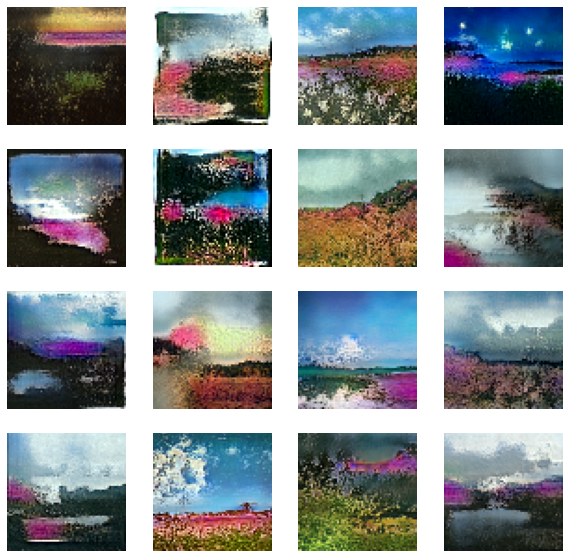

In [ ]:
tf.random.set_seed(196)
batch_size = 16
z = tf.random.normal((batch_size, style_gan.z_dim))
w = style_gan.mapping(z)
noise = style_gan.generate_noise(batch_size=batch_size)
images = style_gan({"style_code": w, "noise": noise, "alpha": 1.0})
plot_images2(images, 5)

In [ ]:

from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from numpy import asarray

def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

def calculate_inception_score(images, n_split=10, eps=1E-16):

    model = InceptionV3()
    processed = images.astype('float32')
    processed = scale_images(processed, (299,299,3))
    processed = preprocess_input(processed)
    yhat = model.predict(processed)
    scores = list()
    n_part = floor(images.shape[0] / n_split)
    for i in range(n_split):
        ix_start, ix_end = i * n_part, i * n_part + n_part
        p_yx = yhat[ix_start:ix_end]
        p_y = expand_dims(p_yx.mean(axis=0), 0)
        kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
        sum_kl_d = kl_d.sum(axis=1)
        avg_kl_d = mean(sum_kl_d)
        is_score = exp(avg_kl_d)
        scores.append(is_score)
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

val_test_size = 32
z_val = tf.random.normal((val_test_size, style_gan.z_dim))
noise = style_gan.generate_noise(val_test_size)
i = style_gan({"z": z_val, "noise": noise, "alpha": 1.0})
print(i.shape)
is_avg, is_std = calculate_inception_score(i)
print('score', is_avg, is_std)

(32, 64, 64, 3)
1/1 [==============================] - 3s 3s/step
score 1.7438586 0.19697617


In [ ]:
# calculate frechet inception distance
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
import torch
import torchvision
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader


def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)


def calculate_fid(model, images1, images2):
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    ssdiff = numpy.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))


transform=T.Compose([T.Resize((64,64)),
                     T.ToTensor()])

test_dataset = datasets.ImageFolder('./landscapes/test',transform=transform)
test_loader = DataLoader(test_dataset, 32, shuffle=True, num_workers=2)

count=0
fid=0
for t, (real, y) in enumerate(test_loader):
    if count==0:
        new=real.numpy()
        val_test_size = 32
        z_val = tf.random.normal((val_test_size, style_gan.z_dim))
        noise = style_gan.generate_noise(val_test_size)
        i = style_gan({"z": z_val, "noise": noise, "alpha": 1.0})

        images1 = new.astype('float32')
        images2 = i.astype('float32')

        images1 = scale_images(images1, (299,299,3))
        images2 = scale_images(images2, (299,299,3))
        # pre-process images
        images1 = preprocess_input(images1)
        images2 = preprocess_input(images2)
        # calculate fid
        count+=1
        fid = calculate_fid(model, images1, images2)
    else:
        continue
print("fid "+str(fid))




1/1 [==============================] - 0s 103ms/step
fid 503.59355906287954
